In [1]:

from glob import glob

import pandas as pd
import seaborn as sns

from category_encoders import OneHotEncoder
from IPython.display import VimeoVideo
from ipywidgets import Dropdown, FloatSlider, IntSlider, interact
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge  # noqa F401
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.utils.validation import check_is_fitted


In [40]:
def wrangle(filepath):
    # Read CSV file
    df = pd.read_csv(filepath, encoding='latin-1')

    # Subset data: Apartments in "Capital Federal", less than 400,000
    mask_ba = df["place_with_parent_names"].str.contains("Capital Federal")
    mask_apt = df["property_type"] == "apartment"
    mask_price = df["price_aprox_usd"] < 400_000
    df = df[mask_ba & mask_apt & mask_price]

    # Subset data: Remove outliers for "surface_covered_in_m2"
    low, high = df["surface_covered_in_m2"].quantile([0.1, 0.9])
    mask_area = df["surface_covered_in_m2"].between(low, high)
    df = df[mask_area]

    # Split "lat-lon" column
    df[["lat", "lon"]] = df["lat-lon"].str.split(",", expand=True).astype(float)
    df.drop(columns="lat-lon", inplace=True)

    # Get place name
    df["neighborhood"] = df["place_with_parent_names"].str.split("|", expand=True)[3]
    df.drop(columns="place_with_parent_names", inplace=True)
    
    df.drop(columns=["floor", 'expenses'], inplace=True)
    
    df.drop(columns=["operation", 'property_type', 'currency', 'properati_url'], inplace=True)
    
    df.drop(columns=[
         'price',
         'price_aprox_local_currency',
         'price_per_m2',
         'price_usd_per_m2'
            ], inplace=True)
    
    df.drop(columns=["surface_total_in_m2", 'rooms'], inplace=True)
    
    return df

In [6]:
files = glob("data/buenos-aires-real-estate-*.csv")

files

['data\\buenos-aires-real-estate-1.csv',
 'data\\buenos-aires-real-estate-2.csv',
 'data\\buenos-aires-real-estate-3.csv',
 'data\\buenos-aires-real-estate-4.csv',
 'data\\buenos-aires-real-estate-5.csv']

In [41]:
frames = [wrangle(file) for file in files]
frames[0].head()



,price_aprox_usd,surface_covered_in_m2,lat,lon,neighborhood
4,129000.0,70.0,-34.584651,-58.454693,Chacarita
9,87000.0,42.0,-34.638979,-58.500115,Villa Luro
29,118000.0,54.0,-34.615847,-58.459957,Caballito
40,57000.0,42.0,-34.625222,-58.382382,Constitución
41,90000.0,50.0,-34.610610,-58.412511,Once


In [42]:
df = pd.concat(frames, ignore_index=True)
df.shape

(6582, 5)

In [17]:
# df.isnull().sum()
df.isnull().sum() / len(df)

operation                     0.000000
property_type                 0.000000
price                         0.000000
currency                      0.000000
price_aprox_local_currency    0.000000
price_aprox_usd               0.000000
surface_total_in_m2           0.278031
surface_covered_in_m2         0.000000
price_usd_per_m2              0.310848
price_per_m2                  0.000000
rooms                         0.196901
properati_url                 0.000000
lat                           0.040413
lon                           0.040413
neighborhood                  0.000000
dtype: float64

In [19]:
df.select_dtypes('object').head()

,operation,property_type,currency,properati_url,neighborhood
0,sell,apartment,USD,http://chacarita.properati.com.ar/10qlv_venta_...,Chacarita
1,sell,apartment,USD,http://villa-luro.properati.com.ar/12m82_venta...,Villa Luro
2,sell,apartment,USD,http://caballito.properati.com.ar/11wqh_venta_...,Caballito
3,sell,apartment,USD,http://constitucion.properati.com.ar/k2f0_vent...,Constitución
4,sell,apartment,USD,http://once.properati.com.ar/suwa_venta_depart...,Once


In [21]:
df.select_dtypes('object').nunique()

operation           1
property_type       1
currency            2
properati_url    6582
neighborhood       57
dtype: int64

In [27]:
sorted(df.columns)

['lat',
 'lon',
 'neighborhood',
 'price',
 'price_aprox_local_currency',
 'price_aprox_usd',
 'price_per_m2',
 'price_usd_per_m2',
 'rooms',
 'surface_covered_in_m2',
 'surface_total_in_m2']

In [43]:
corr= df.select_dtypes('number').drop(columns='price_aprox_usd').corr()
corr

,surface_covered_in_m2,lat,lon
surface_covered_in_m2,1.000000,0.028538,0.034515
lat,0.028538,1.000000,-0.262439
lon,0.034515,-0.262439,1.000000


<AxesSubplot:>

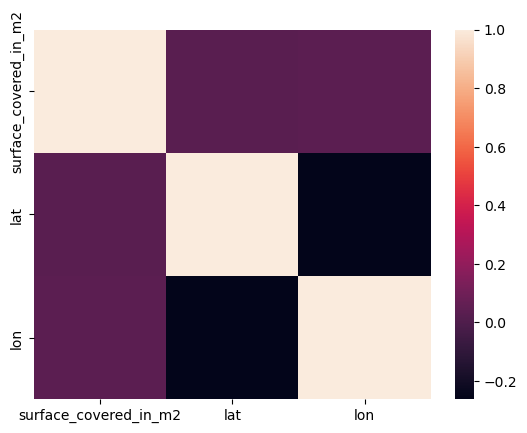

In [44]:
sns.heatmap(corr)

In [45]:
features = ['surface_covered_in_m2', 'lat', 'lon', 'neighborhood']
target = 'price_aprox_usd'


X_train = df[features]
y_train = df[target]

In [46]:
y_mean = y_train.mean()
y_mean

132383.83701458527

In [48]:
y_pred_baseline = [y_mean] * len(y_train)
# print(y_pred_baseline[:5])


mae_baseline = mean_absolute_error(y_train, y_pred_baseline)
print(mae_baseline)

44860.10834274134


In [49]:
model = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    SimpleImputer(),
#     LinearRegression()    
    Ridge()
)

model.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['neighborhood'], use_cat_names=True)),
                ('simpleimputer', SimpleImputer()), ('ridge', Ridge())])

In [50]:
y_pred_training = model.predict(X_train)
mae_training = mean_absolute_error(y_train, y_pred_training)
print("Training MAE:", round(mae_training, 2))

Training MAE: 24207.11


In [59]:
def make_prediction(area, lat, lon, neighborhood):
    data = {
        'surface_covered_in_m2': area,
        'lat': lat,
        "lon": lon,
        'neighborhood': neighborhood
    }
    df = pd.DataFrame(data, index=[0])
    
    prediction = model.predict(df)[0].round(2)
    return f"Predicted apartment price: ${prediction}"

In [60]:
make_prediction(110, -34.60, -58.46, "Villa Crespo")

'Predicted apartment price: $250775.11'

In [61]:
interact(
    make_prediction,
    area=IntSlider(
        min=X_train["surface_covered_in_m2"].min(),
        max=X_train["surface_covered_in_m2"].max(),
        value=X_train["surface_covered_in_m2"].mean(),
    ),
    lat=FloatSlider(
        min=X_train["lat"].min(),
        max=X_train["lat"].max(),
        step=0.01,
        value=X_train["lat"].mean(),
    ),
    lon=FloatSlider(
        min=X_train["lon"].min(),
        max=X_train["lon"].max(),
        step=0.01,
        value=X_train["lon"].mean(),
    ),
    neighborhood=Dropdown(options=sorted(X_train["neighborhood"].unique())),
);

interactive(children=(IntSlider(value=53, description='area', max=101, min=30), FloatSlider(value=-34.59890626…